<a href="https://colab.research.google.com/github/Nelson-Muteti/Naive_Bayes-and-KNN_Project/blob/main/Nelson_Muteti_KNN_IP_Week_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Defining The Question

We are supposed to build a KNN machine Learning Model on Titanic dataset training data and be able to accurately predict survival probability of passengers aboard given several features. After optimizing the model, we are to apply it to a given unseen data (test data)

In [208]:
#import necessary libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Defining Metrics for Success

A satisfactory project will involve all steps of the CRISP DM including Data preparation, data cleaning,evaluation, data Modelling and finally deployment of model to test data.

## Understanding The context.

The context here involves the disaster surrounding the Titanic ship. The Titanic was a  British passenger liner operated by the White Star Line that sank in the North Atlantic Ocean on 15 April 1912, after striking an iceberg during her maiden voyage from Southampton to New York City.



## Experimental Design

As mentioned above, we will first clean the data, do some exploratory data analyis before embarking on the main problem : building a KNN ML model. All will be done in accordance to CRISP DM.

## Read the data

In [209]:
#load data into notebook
train_df = pd.read_csv('/content/train (5).csv')
test_df = pd.read_csv('/content/test (1) (1).csv')


In [210]:
#check makeup of data
print(train_df.shape)
print(test_df.shape)
#we have 891 rows of data in train set and only 418 in the test data


(891, 12)
(418, 11)


In [211]:
#view top of the train dataset
train_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [212]:
#view top of test dataset
test_df.head(2)
#survived column is our target / label since it is not included in the test data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S


In [213]:
#check if correct datatypes are applied
train_df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

## External Data Validation

To validate the integrity of the data , I used [this Wikipedia information](https://en.wikipedia.org/wiki/Titanic). The  integrity of the dataset was validated.

## Data Cleaning

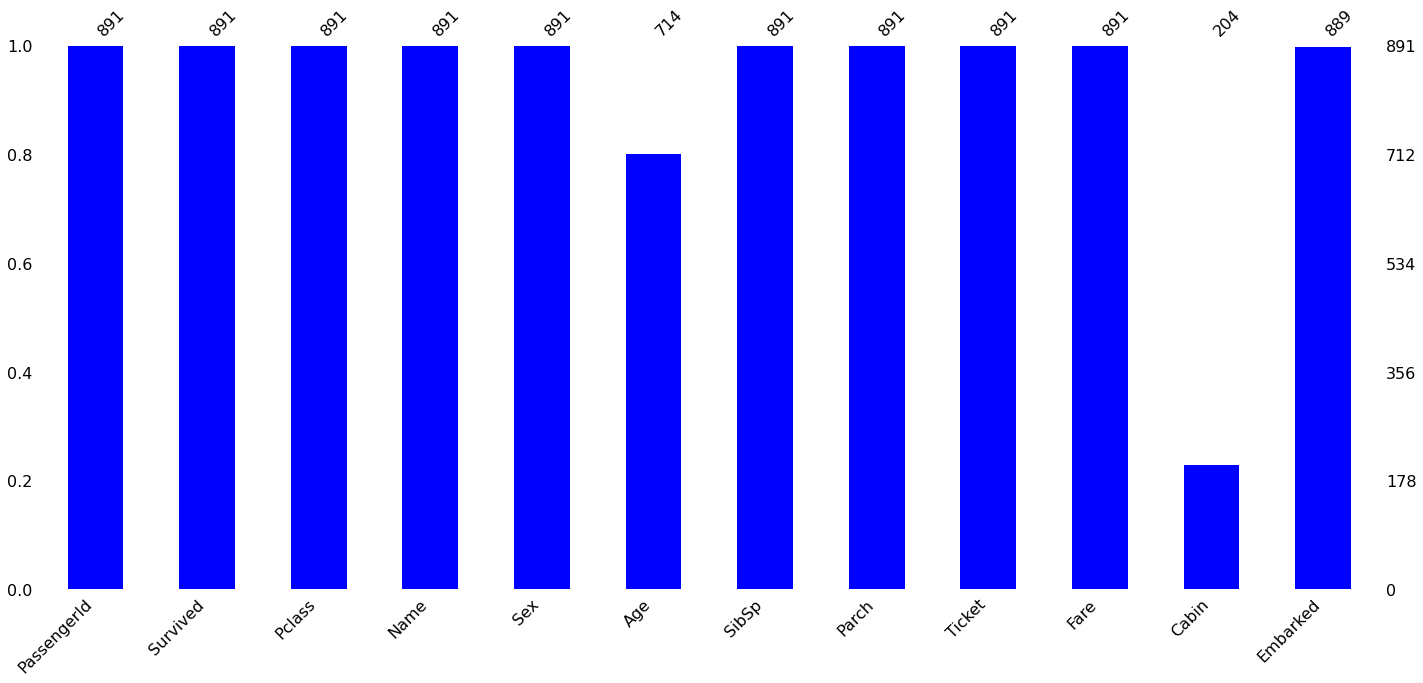

In [214]:
#clean each dataset independently
#first begin with train data

import missingno as msno

msno.bar(train_df,color = 'blue')

In [215]:
#the age, cabin and embarked columns seem to have NA values

#particularly, the cabin column has way too many missing values

#imputing the values would skew our findings

train_df.drop(['Cabin'],axis=1,inplace=True)

In [216]:
#also,name, passenger ID and ticket number are not important to our model

train_df.drop(['PassengerId','Name','Ticket'],axis=1,inplace=True)

In [217]:
train_df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C


In [218]:
train_df.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [219]:
train_df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

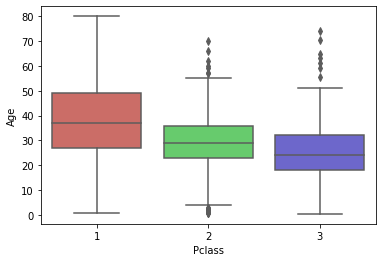

In [220]:
# Let's look at how passenger age is related to their class as a passenger on the boat.
# 
sns.boxplot(x='Pclass', y='Age', data=train_df, palette='hls')

In [221]:
#find average per class and impute NA values with it
class_age = train_df.groupby(['Pclass'])['Age'].mean()
class_age

Pclass
1    38.233441
2    29.877630
3    25.140620
Name: Age, dtype: float64

In [222]:
# So let's write a function that finds each null value in the Age variable, and for each null, 
# checks the value of the Pclass and assigns an age value according to the average age of passengers in that class.
#
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 38
        elif Pclass == 2:
            return 29
        else:
            return 25
    else:
        return Age

In [223]:
train_df['Age'] = train_df[['Age', 'Pclass']].apply(age_approx, axis=1)
train_df['Age'].describe()

count    891.000000
mean      29.252716
std       13.211959
min        0.420000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [224]:
#train_df['Age'].interpolate(method='linear', inplace=True, limit_direction="both")
#use a linear interpolation to impute missing values for age column

In [225]:
train_df['Age'].describe()

count    891.000000
mean      29.252716
std       13.211959
min        0.420000
25%       22.000000
50%       26.000000
75%       37.000000
max       80.000000
Name: Age, dtype: float64

In [226]:
#fill na value for Embarked column with the most occuring
train_df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [227]:
train_df = train_df.fillna(train_df['Embarked'].value_counts().index[0])

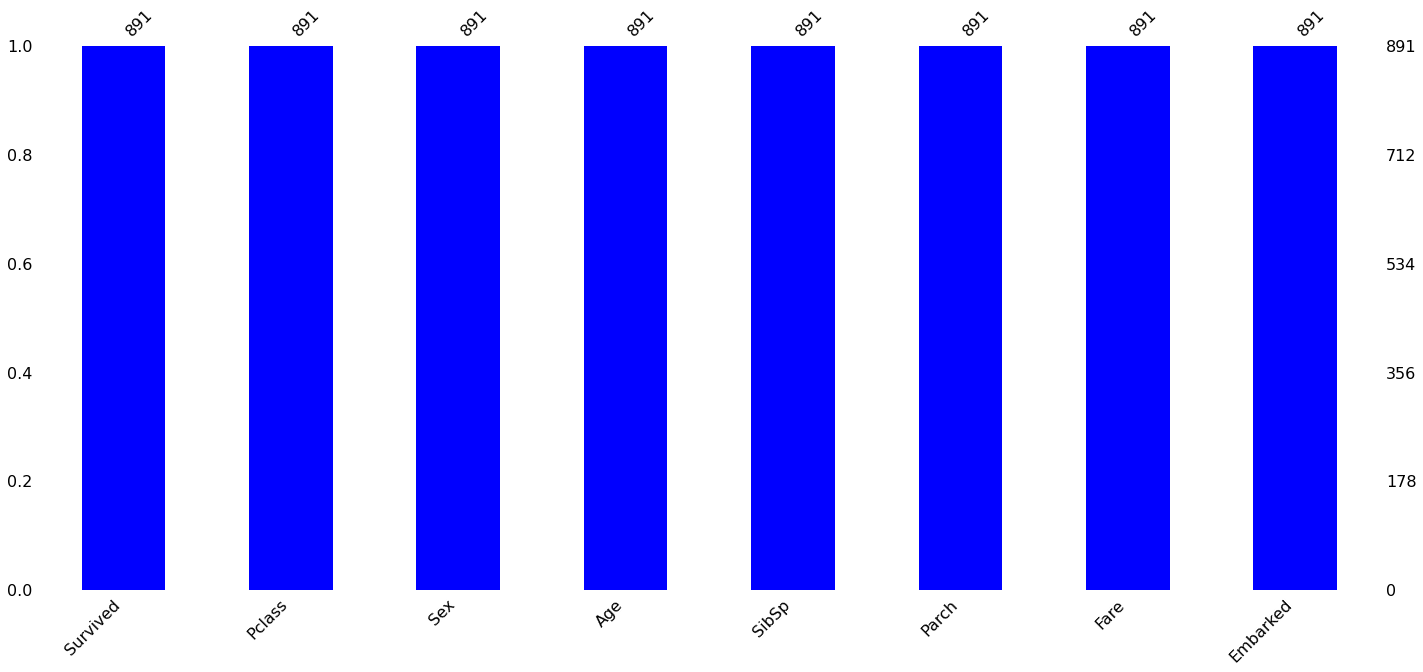

In [228]:
msno.bar(train_df,color = 'blue')
#confirming that there are no more missing values in data

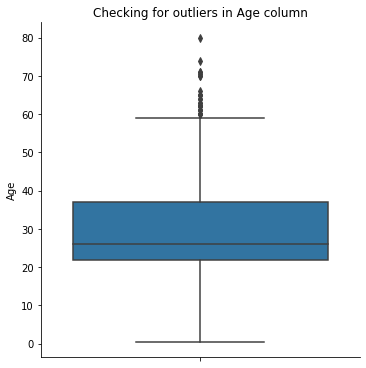

In [229]:
#now lets check for outliers in train data

sns.catplot(y = 'Age',data = train_df,kind = 'box')
plt.title('Checking for outliers in Age column')
plt.show()

#just a few outliers which are not really far from 3rd quartile

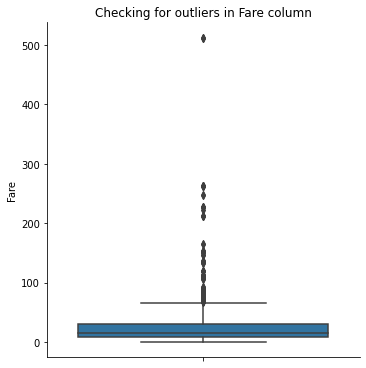

In [230]:
#now lets check for outliers in train data

sns.catplot(y = 'Fare',data = train_df,kind = 'box')
plt.title('Checking for outliers in Fare column')
plt.show()

In [231]:
#check the outliers in the Fare column
outliers=[]

def detect_outlier(train_df):
    
    threshold=3
    mean_1 = np.mean(train_df)
    std_1 =np.std(train_df)
    
    for y in train_df:
        z_score= (y - mean_1)/std_1 
        if np.abs(z_score) > threshold:
            outliers.append(y)
    return outliers

print(detect_outlier(train_df['Fare']))
len(detect_outlier(train_df['Fare']))

#36 outliers in fare column

[263.0, 263.0, 247.5208, 512.3292, 247.5208, 262.375, 263.0, 211.5, 227.525, 263.0, 221.7792, 227.525, 512.3292, 211.3375, 227.525, 227.525, 211.3375, 512.3292, 262.375, 211.3375]


40

In [232]:
#I have to get the Interquartile range
Q1 = train_df.quantile(0.25)
Q3 = train_df.quantile(0.75)
IQR = Q3 - Q1
df = train_df[~((train_df < (Q1 - 1.5 * IQR)) | (train_df > (Q3 + 1.5 * IQR))).any(axis=1)]
print(df.shape)
print(train_df.shape)

(589, 8)
(891, 8)


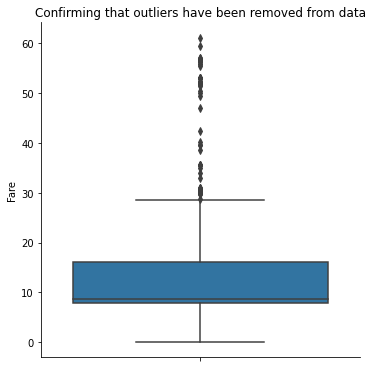

In [233]:
#now, checking for outliers in fare column we have
sns.catplot(y = 'Fare',data = df,kind = 'box')
plt.title('Confirming that outliers have been removed from data')
plt.show()

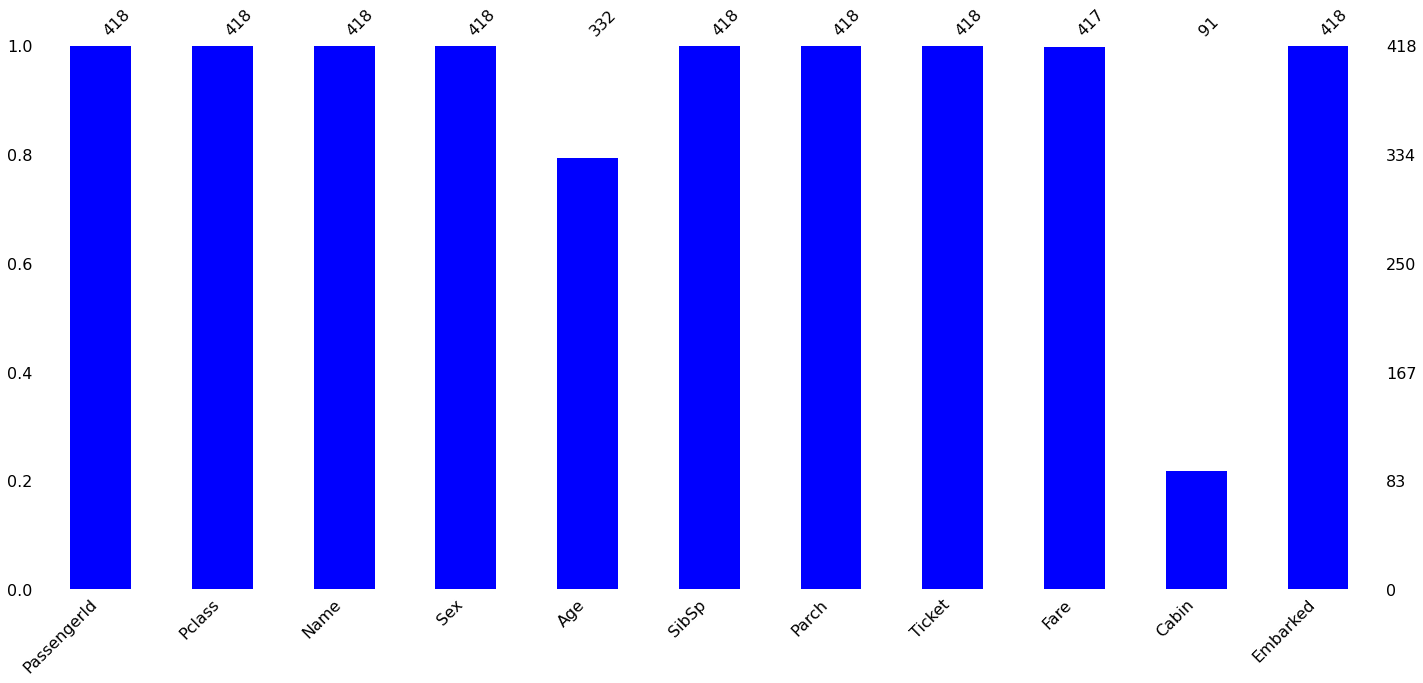

In [234]:
#now clean the test data

msno.bar(test_df,color = 'blue')

In [235]:
#the age, cabin and fare columns seem to have NA values

#particularly, the cabin column has way too many missing values


test_df.drop(['Cabin'],axis=1,inplace=True)

In [236]:
test_df.drop(['Name','Ticket'],axis=1,inplace=True)
#drop columns that may not be used for modelling

In [237]:
print(test_df['Age'].describe())

grouped = test_df.groupby(['Pclass'])['Age'].mean()

grouped

count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64


Pclass
1    40.918367
2    28.777500
3    24.027945
Name: Age, dtype: float64

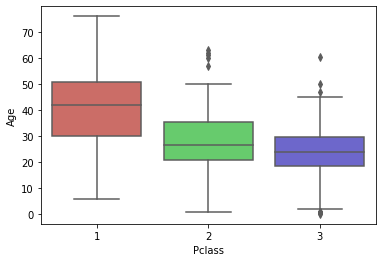

In [238]:
# Let's look at how passenger age is related to their class as a passenger on the boat.
#just like we did with train data, impute for age and fare columns
sns.boxplot(x='Pclass', y='Age', data=test_df, palette='hls')

In [239]:
#function 
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1:
            return 40
        elif Pclass == 2:
            return 28
        else:
            return 24
    else:
        return Age

In [240]:
test_df['Age'] = test_df[['Age', 'Pclass']].apply(age_approx, axis=1)
test_df['Age'].describe()
#newly imputed data is inline with initial data

count    418.000000
mean      29.374402
std       12.950690
min        0.170000
25%       23.000000
50%       25.000000
75%       36.375000
max       76.000000
Name: Age, dtype: float64

In [241]:
test_df['Fare'].describe()

count    417.000000
mean      35.627188
std       55.907576
min        0.000000
25%        7.895800
50%       14.454200
75%       31.500000
max      512.329200
Name: Fare, dtype: float64

In [242]:
#imputing fare data
test_df['Fare'].interpolate(method='linear', inplace=True, limit_direction="both")
test_df['Fare'].describe()

count    418.000000
mean      35.565974
std       55.854524
min        0.000000
25%        7.895800
50%       14.454200
75%       31.471875
max      512.329200
Name: Fare, dtype: float64

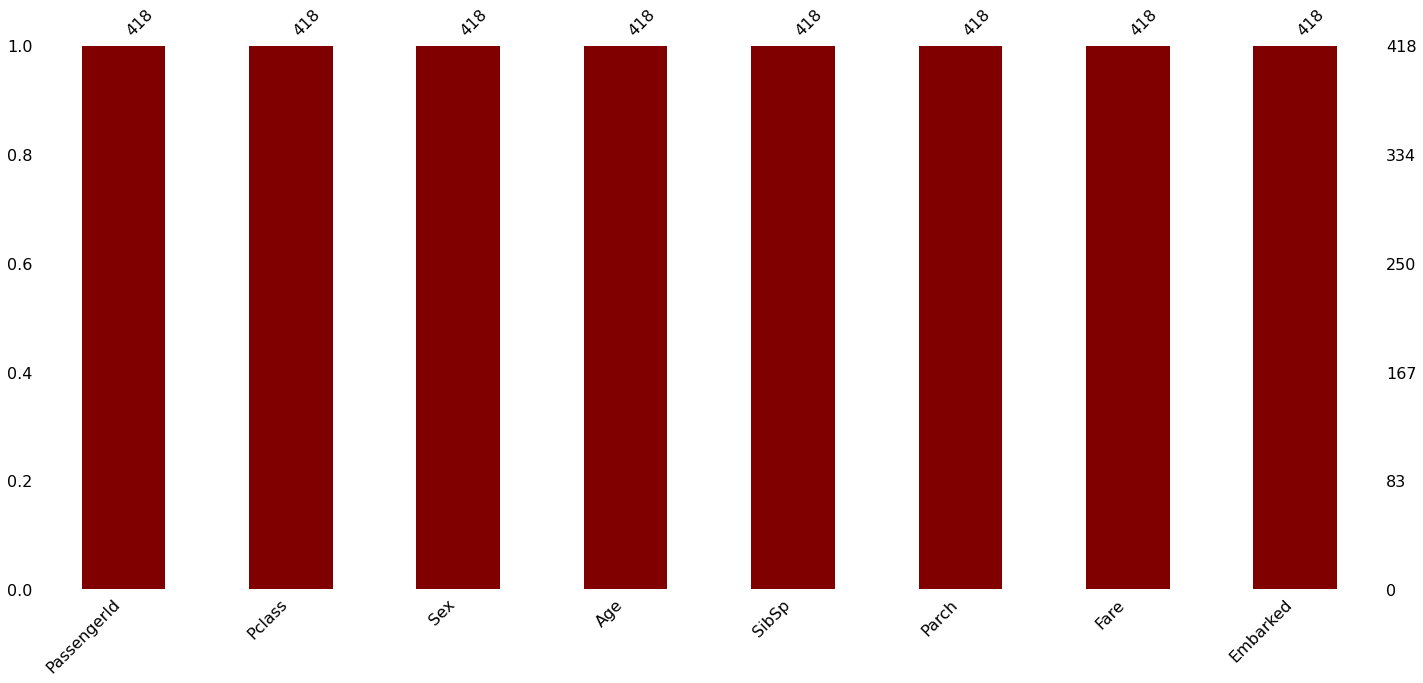

In [243]:
#now check for any missing values in data
msno.bar(test_df,color = 'maroon')

In [244]:
df.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

## Exploratory Data Analysis

First Univariate EDA then Bivariate and Multivariate Analysis to understand and visualize the data and understand underlying patterns.

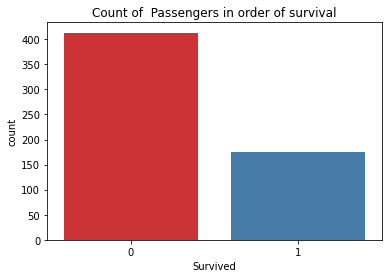

In [245]:
#now for some EDA on train data
#univariate

sns.countplot(x = 'Survived',data = df,palette='Set1')
plt.title('Count of  Passengers in order of survival')
plt.show()

#majority of passengers did not survive (0)

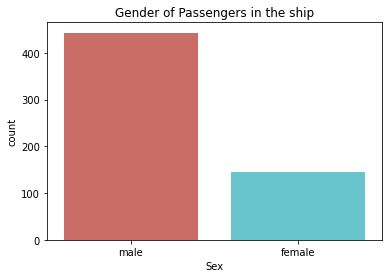

In [246]:
sns.countplot(x = 'Sex',data = df,palette = 'hls')
plt.title('Gender of Passengers in the ship')
plt.show()

#majority of passengers in the ship are male

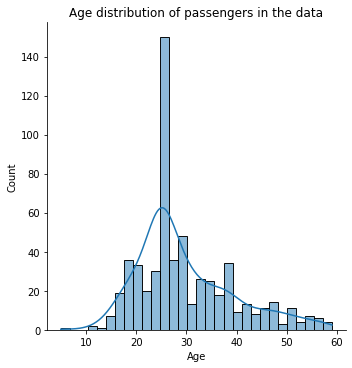

In [247]:
#distribution of ages

sns.displot(df['Age'],kde = True,bins = 30)
plt.title('Age distribution of passengers in the data')
plt.show()

#ages seem to be normally distributed

In [248]:
#check for normality of age distribution in data using
#null hypothesis states that data is Normally distributed

from scipy.stats import shapiro
stat,p = shapiro(df.Age)
print((stat,p))
alpha = 0.005
if stat > alpha:
  print('Normal Distribution')
else:
  print('Not Normal Distribution')

(0.9245511293411255, 1.3179030624954982e-16)
Normal Distribution


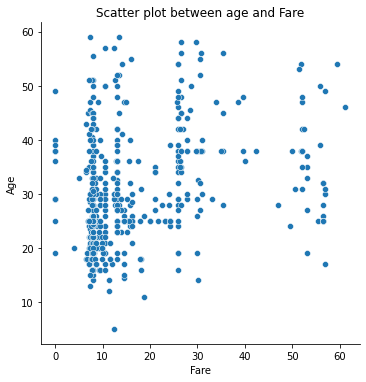

In [249]:
#now for some bivariate analysis

sns.relplot(x = 'Fare',y = 'Age',data = df)
plt.title('Scatter plot between age and Fare')
plt.show()

In [250]:
#get the correlation coeffient beween age and fare 

mycoef = df['Age'].corr(df['Fare'])#
print(mycoef)

#very weak correlation between Fare and Age of passengers

0.32441045382044964


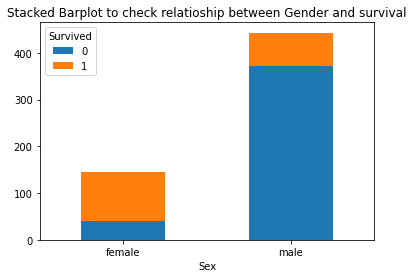

In [251]:
mytab = pd.crosstab(index=df['Sex'],columns=df['Survived'])

mytab.plot(kind="bar",stacked=True)
plt.title('Stacked Barplot to check relatioship between Gender and survival')
plt.xticks(rotation = 0)
plt.show()

#relationship between gender and survival


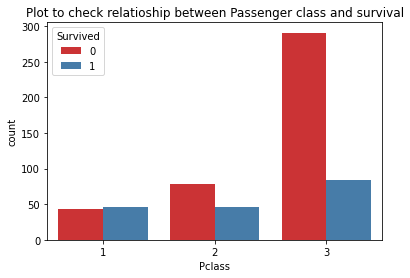

In [252]:
sns.countplot(x = 'Pclass',hue = 'Survived',palette='Set1',data = df)
plt.title('Plot to check relatioship between Passenger class and survival')
plt.show()
#relationship between Passenger class and survival

# almost 50% of passengers in first class survived while a disproportionate number  

#  of passengers in other classes did not survive

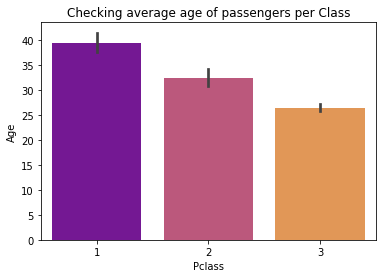

In [253]:
sns.barplot(x ='Pclass', y ='Age', data = df,
            palette ='plasma', estimator = np.mean)
plt.title('Checking average age of passengers per Class')
plt.show()

#the average age of passengers reduces with class

# First class passengers are older on average compared to subsequent classes.

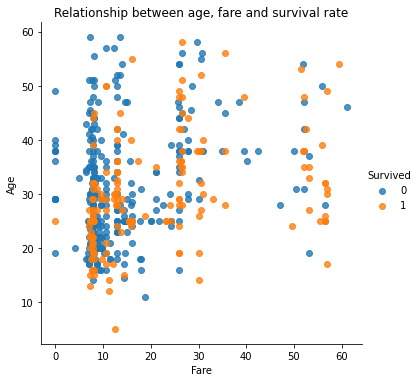

In [254]:
#now for multivariate analysis

sns.lmplot(x = 'Fare',y = 'Age',hue='Survived',data = df,fit_reg=False)
plt.title('Relationship between age, fare and survival rate')
plt.show()

# There doesnt seem to be an obvious trend between age, fare and survival
# but the higher a passengers' fare and older the higher the chances of survival

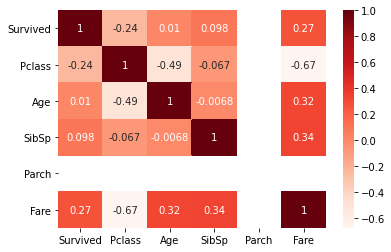

In [255]:
sns.heatmap(df.corr(), annot=True, cmap = 'Reds')
plt.show()

#now lets check a correlation heatmap of feature variables and target

#there doesnt seem to be any strong correlations between variables and thus we can use all the variables for

# initial modelling.


## Implementing the solution

First, lets correct any data Imbalance for better modelling and to avoid data leakage. This will be done by **downsampling the data and getting a proportional representation of the target column values.**

In [256]:
#now lets downsample our data

from sklearn.utils import resample

df['Survived'].value_counts()

#we are going to include all data points for passengers who survived and a proportionate number for those who did

# not survive

0    413
1    176
Name: Survived, dtype: int64

In [257]:
sur1_df = df[df['Survived'] == 1]
sur1_df.shape

(176, 8)

In [258]:
sur_df = df[df['Survived'] == 0]
#first subset passengers who did not survive
sur_df.shape

(413, 8)

In [259]:
sur_sample = resample(sur_df,replace = False,n_samples = 178,random_state = 42)

#get a random sample of data from passengers who did not survive

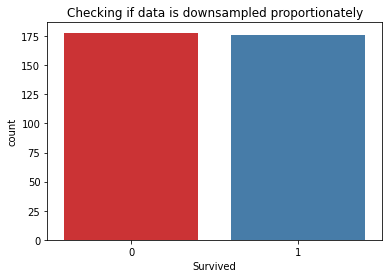

In [260]:
#concatenate both datasets to get one downsampled and proportionate dataset

newdf = pd.concat([sur_sample,sur1_df])

sns.countplot(x = 'Survived',data = newdf,palette='Set1')
plt.title('Checking if data is downsampled proportionately')

plt.show()

Now that the data is well sampled (proportionally), lets proceed to encode categorical features.

### Data Pre-processing

First encode the categorical columns.

In [261]:
#now lets encode and scale our data

newdf.dtypes

Survived      int64
Pclass        int64
Sex          object
Age         float64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
dtype: object

In [262]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

enc = newdf.dtypes == object

myfilt = newdf.columns[enc].tolist()

newdf[myfilt] = newdf[myfilt].apply(lambda x:le.fit_transform(x))

newdf.head(2)

#now the categorical columns are encoded

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
854,0,2,0,44.0,1,0,26.00,2
767,0,3,0,30.5,0,0,7.75,1


In [263]:
newdf.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked'],
      dtype='object')

Next, scale the data to avoid effect of any remaining outliers on model. For this we use **StandardScaler()**

In [264]:
#lets get to implementation of problem

from sklearn.preprocessing import StandardScaler

feat = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']

X = newdf[feat].values

y = newdf['Survived'].values

In [265]:
scaler = StandardScaler()

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 0)

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

**Now lets fit a K Nearest Neighbours model and test with 80 - 20 train - test ratio.**

In [266]:
#now fit the KNN model

from sklearn.neighbors import KNeighborsClassifier

model1 = KNeighborsClassifier(n_neighbors=5)

model1.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [267]:
#now check the accuracy metrics

# Model 1

mypred1 = model1.predict(X_test)
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

print('accuracy : ',accuracy_score(mypred1,y_test) * 100)

print('')
print(confusion_matrix(mypred1,y_test))
print('')
print('f1 Score : ',f1_score(mypred1,y_test) * 100)
# 69.44 % accuracy with 0.2 test size and automatic metrics

accuracy :  70.4225352112676

[[30 15]
 [ 6 20]]

f1 Score :  65.57377049180327


**About 70.4 % general accuracy with an F1_ Score of  65.57%. Lets see if the F1_score and accuracy will increase with optimization of test_size.**

**Model 2 ( 70 - 30 ) test size ratio.**

In [268]:
#now, changing the test size and other metrics

from sklearn.preprocessing import StandardScaler

feat = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']

X = newdf[feat].values

y = newdf['Survived'].values

In [269]:
# Model 2
scaler = StandardScaler()

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 0)

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier

model2 = KNeighborsClassifier(n_neighbors=5,metric = 'minkowski')

model2.fit(X_train,y_train)

y_pred = model2.predict(X_test)
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

print('accuracy : ',accuracy_score(y_pred,y_test) * 100)

print('')
print(confusion_matrix(y_pred,y_test))
print('')
print('f1 Score : ',f1_score(y_pred,y_test) * 100)

accuracy :  71.02803738317756

[[47 22]
 [ 9 29]]

f1 Score :  65.1685393258427


**On using a manhattan metric distance, the accuracy score remains constant.**

**Increasing the test size to 30 % increases the accuracy from 70 % to 71 % while the f1_score is at 65.1%.**

**Model 3 (Test size 60 - 40 )**

In [270]:
#now, changing the test size and other metrics

# Model 3

from sklearn.preprocessing import StandardScaler

feat = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']

X = newdf[feat].values

y = newdf['Survived'].values

scaler = StandardScaler()

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.4,random_state = 0)

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier

mymodel = KNeighborsClassifier(n_neighbors=9,metric = 'minkowski')

mymodel.fit(X_train,y_train)

mypred = mymodel.predict(X_test)
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

print('accuracy : ',accuracy_score(mypred,y_test) * 100)

print('')
print(confusion_matrix(mypred,y_test))
print('')
print('f1 Score : ',f1_score(mypred,y_test) * 100)

accuracy :  76.05633802816901

[[56 17]
 [17 52]]

f1 Score :  75.36231884057972


**So far, the highest accuracy and F1_scores at 76% and 75 % respectively when the test size is at 60 - 40**

Lets try to use **LDA as our Dimensionality reduction** technique and check our metrics.

In [271]:

# Model 4

from sklearn.preprocessing import StandardScaler

feat = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']

X = newdf[feat].values

y = newdf['Survived'].values

scaler = StandardScaler()

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 0)

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda =  LinearDiscriminantAnalysis(n_components=1)

X_train = lda.fit_transform(X_train,y_train)

X_test = lda.transform(X_test)



from sklearn.neighbors import KNeighborsClassifier

ldamodel = KNeighborsClassifier(n_neighbors=5,metric = 'manhattan')

ldamodel.fit(X_train,y_train)

ypred = ldamodel.predict(X_test)
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score

print('accuracy : ',accuracy_score(ypred,y_test) * 100)

print('')
print(confusion_matrix(ypred,y_test))
print('')
print('f1 Score : ',f1_score(ypred,y_test) * 100)

accuracy :  73.23943661971832

[[30 13]
 [ 6 22]]

f1 Score :  69.84126984126985


On applying a Linear Discriminant Analysis reduction technique, accuracy reduces to 75 % while the f1_score reduces to 69.8%

## Applying model on Test data

Since **Model 3 (60 - 40 train - test ratio)** had by far the best metrics including a very high F1_score, it means that it can generalise on unseen data. We therefore pick Model 3 as our model to fit on test data.

In [272]:
#now fit the third the model in the test data

# encode test data

#first remove the passenger ID column

mydata = test_df['PassengerId']

test_df.drop(['PassengerId'],axis=1,inplace=True)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

enc = test_df.dtypes == object

myfilt = test_df.columns[enc].tolist()

test_df[myfilt] = test_df[myfilt].apply(lambda x:le.fit_transform(x))

test_df.head(2)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.5,0,0,7.8292,1
1,3,0,47.0,1,0,7.0000,2


In [273]:
# fit  Model 3

from sklearn.preprocessing import StandardScaler

feat = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare','Embarked']

X = test_df[feat].values

#scale test data just as we scaled train data

X = scaler.fit_transform(X)

# now predict on test data

mypred = mymodel.predict(X)


Now that the model has been fitted on test data, we can append the target column ( survived ) column to the initial test data.

In [274]:
#append the results of model to those of input data

final_df = pd.read_csv('/content/test (1) (1).csv')
final_df['Survived'] = mypred


final_df.head(5)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


**Now we have our test data with the Survival status predictions appended for all test data passengers.**

## Recommendations

Since Model 3 performed a better job of classification, we used it for our Titanic test data. This model has a high F1_score ensuring that our True Positives in the confusion matrix are comparatively high, hence doing a good job of precision and recall.